### RVM vs. OLS Regression for Preessure/flow rate outlet relatioship
**Author**: Daniele E. Schiavazzi

**Date**: June 21st, 2017

**Objectives of this tutorial**:
- **Refresh** ordinary least squares regression (OLS).
- Introduce **relevance vector machine** and an implementation.
- **Demonstrate application** on pressure/flow interface regression for surregate modeling geometrical multiscale cardiovascular models.

#### PART I: Read interface pressure/flow from SimVascular output
When coupled with a peripheral circulation 0D model, SimVascular write all interface pressure/flow in the following files
- **Qgeneral**: Contains all interface flows at each time step.
- **Pgeneral**: Contains all interface pressures at each time step.

Let's open two sample files and see what they contain.

Total Number of interfaces: 20
Total Number of timesteps: 702


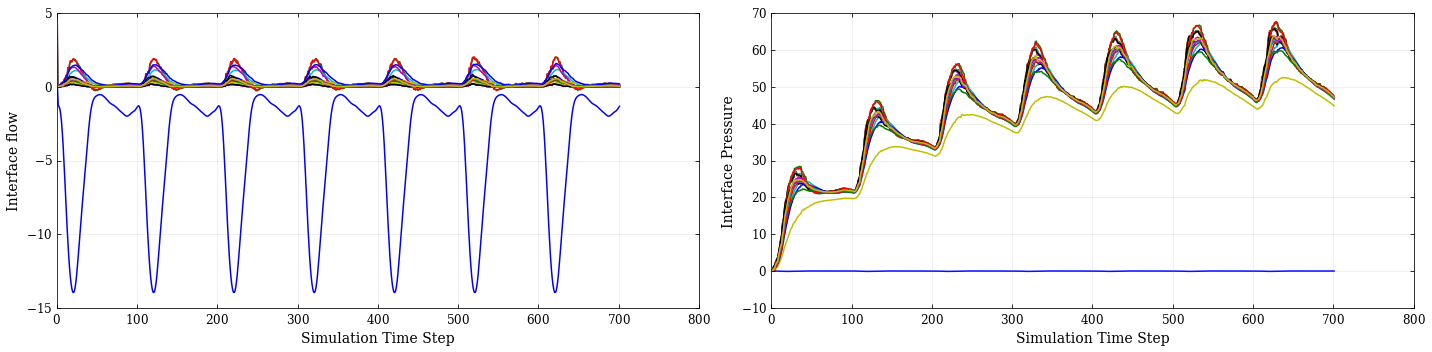

In [129]:
# Imports
import sys,math
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
from common import *

# READ PRESSURES AND FLOWS FROM FILE
qVals = np.loadtxt('Qgeneral')
pVals = np.loadtxt('Pgeneral')

print('Total Number of interfaces: %d' % (qVals.shape[1]))
print('Total Number of timesteps: %d' % (qVals.shape[0]))

# PLOT CONTENT
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(qVals)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.ylim([-15.0,5.0])
plt.subplot(1,2,2)
plt.plot(pVals/133.3)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface Pressure',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

After an initial transient, pressure values progressively stabilize in a periodic steady state. 
Instead of plotting flow and pressure in time, it is interesting to plot them versus each other at specific outlets.

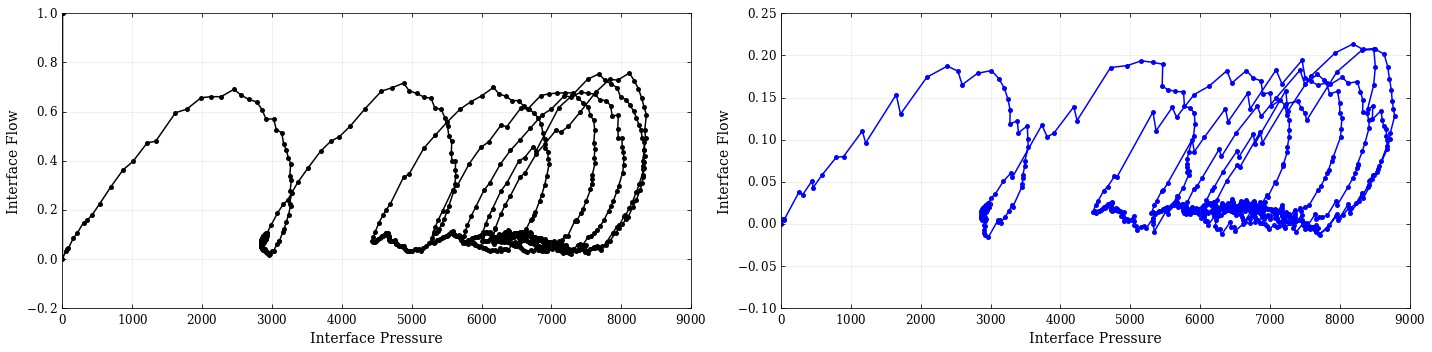

In [130]:
# SELECT OUTLET INDEX
outletIdx1 = 0
outletIdx2 = 6

# PLOT CONTENT
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pVals[:,outletIdx1],qVals[:,outletIdx1],'k-o',markersize=5.0)
plt.xlabel('Interface Pressure',fontsize=14)
plt.ylabel('Interface Flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.subplot(1,2,2)
plt.plot(pVals[:,outletIdx2],qVals[:,outletIdx2],'b-o',markersize=5.0)
plt.xlabel('Interface Pressure',fontsize=14)
plt.ylabel('Interface Flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.ylim([-0.1,0.25])
plt.tight_layout()
plt.show()

#### PART II: Remove initial transient and prepare for regression
The initial transient is removed first to perform regression under steady state conditions.

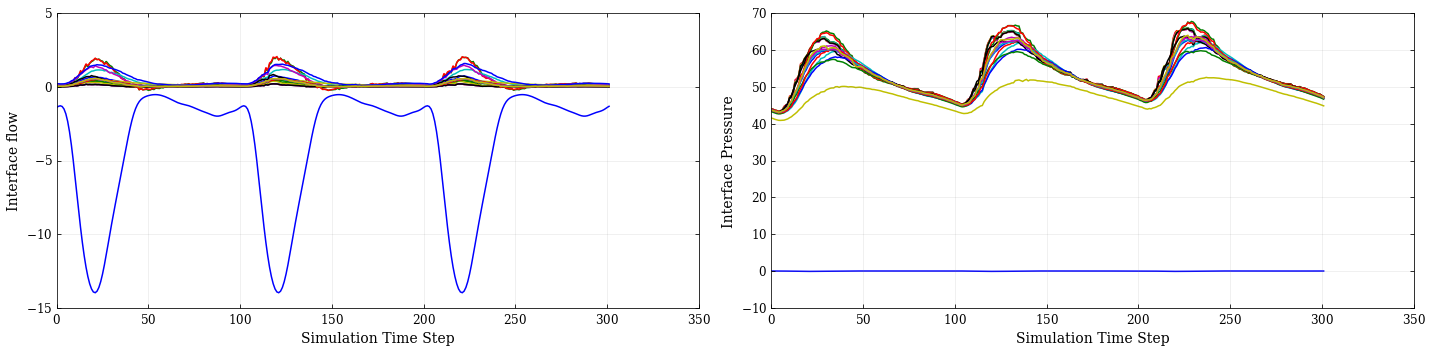

In [131]:
# REMOVE SAMPLES FROM THE INITIAL TRANSIENT
qVals = qVals[400:,:]
pVals = pVals[400:,:]
  
# PLOT CONTENT
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(qVals)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface flow',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.ylim([-15.0,5.0])
plt.subplot(1,2,2)
plt.plot(pVals/133.3)
plt.xlabel('Simulation Time Step',fontsize=14)
plt.ylabel('Interface Pressure',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

We would like to use legendre polynomials for regression. This basis has support in $[-1,1]$ and therefore we need to normalize the input pressures to fit in this interval.
Additionally, we are separating the data in training and testing sets, in order to check the regression accuracy later on in this notebook.

In [132]:
# NORMALIZE DATA
maxP = np.max(pVals,axis=0)
minP = np.min(pVals,axis=0)
minP,maxP = makeSymmetric(minP,maxP)
pVals = normalizeColumns(pVals,minP,maxP)

# EXTRACT NUMBER OF SAMPLES AND OUTLETS
totSamples = qVals.shape[0]
totOutlets = qVals.shape[1]
totInputs  = pVals.shape[1]

# DECIDE NUMBER OF TRAINING AND TESTING SETS
trainSizeRatio = 0.01
trainSize = int(trainSizeRatio*totSamples)

# DETERMINE RANDOM INDEXES TO EXTRACT AND DO TRAINING/TESTING SEPARATION
indices = np.random.permutation(totSamples)
training_idx, test_idx = indices[:trainSize], indices[trainSize:]
pTrainVals, pTestVals = pVals[training_idx,:], pVals[test_idx,:]
qTrainVals, qTestVals = qVals[training_idx,:], qVals[test_idx,:]

The matrix we create contains the Legendre polynomials up to a certain order. Let's plot these polynomials for a **one-dimensional scenario**. Remember that the proposed pressure/flow rate regression aims at computing the flow at one interface by knowing the flow at all the interfaces. **It is therefore a 20-dimensional regression problem**.

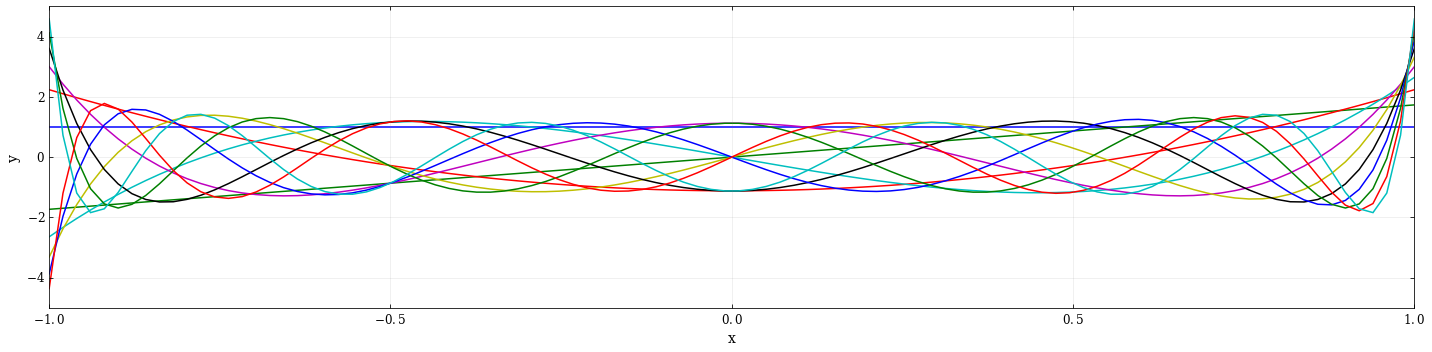

In [133]:
onedInput = 2*np.arange(100)/99.0-1.0
onedInput = np.resize(onedInput,(len(onedInput),1))
onedMat = np.array(buildRegressionMatrix(onedInput,10).getMatrix())
plt.figure(figsize=(20,5))
plt.plot(onedInput,onedMat)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

#### PART III: Polynomial Regression
Now we are ready to build the regression (a.k.a. **measurement**) matrix for our original problem. Due to the problem being 20-dimensional we have to limit the polynomials degree. Let's start with **quadratic interpolation**.

In [134]:
# ASSEMBLE POLYNOMIAL MATRIX FROM TRAINING INPUT PRESSURES
maxPolyDegree = 1
pMat = buildRegressionMatrix(pTrainVals,maxPolyDegree)
print 'Number of Rows in measurement matrix: ',pMat.getRowCount()
print 'Number of Columns in measurement matrix: ',pMat.getColCount()

Number of Rows in measurement matrix:  3
Number of Columns in measurement matrix:  21


### Ordinary Least Squares Regression

Computation of the expansion coefficients $\boldsymbol{\alpha}_i$ for the generic $\Gamma_{i}$ is performed by minimization of the squared error:
%
\begin{equation}\label{equ:squaredErrorMin}
e_i = \sum_{j=1}^{m}\left[\mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i\right]_{s_j}^{2} = (\mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i)^{T}\,(\mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i).
\end{equation}
%
where the notation $[\cdot]_j$ is used to denote the $j$-th components of a vector.
Expression \eqref{equ:squaredErrorMin} is proportional to the negative log-likelihood of the data for a linear statistical model of the form:
%
\begin{equation}\label{equ:statModel}
\mathbf{q}_i = \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i + \boldsymbol{\epsilon}_i,
\end{equation}
%
with normally distributed error vector $\boldsymbol{\epsilon}_i \sim \mathcal{N}(\mathbf{0},\sigma^2\,I)$, and likelihood $\ell_{\boldsymbol{\alpha}_i}(\mathbf{q}_i) = \mathcal{N}(\boldsymbol{\Phi}\,\boldsymbol{\alpha}_i,\sigma^2\,I)$.
The quantity $\mathbf{C}_{q_i} = \sigma^2\,I$ is used in what follows to denote the covariance of the flow rate at $\Gamma_{i}$.
The value of $\boldsymbol{\alpha}_i$ determined by minimizing \eqref{equ:squaredErrorMin} is generally referred to as the OLS estimate of the coefficient vector, is unbiased, and achieves asymptotic efficiency with covariance that attains the Cram\'er-Rao bound \citep[see, e.g.,][]{banks2014modeling}.
Under these conditions, the inverse of the Fisher information matrix evaluated at the optimal estimate $\boldsymbol{\alpha}_i = \boldsymbol{\alpha}_{i,MLE}$ \citep[see, e.g.,][]{rothenberg1971identification} is used to quantify the second order statistics of $\boldsymbol{\alpha}_{i,MLE}$.
This takes the form (note that, in the interest of clarity, we drop the index $i$ in $\boldsymbol{\alpha}_i$):
%
\begin{equation}
\mathcal{I}(\boldsymbol{\alpha}) = \mathbb{E}\left[\left(\frac{\partial\, log\, \ell_{\boldsymbol{\alpha}}(\mathbf{q})}{\partial \boldsymbol{\alpha}}\right)^{T}\left(\frac{\partial\, log\, \ell_{\boldsymbol{\alpha}}(\mathbf{q})}{\partial \boldsymbol{\alpha}}\right)\right]
= -\mathbb{E}\left[\frac{\partial^2\, log\, \ell_{\boldsymbol{\alpha}}(\mathbf{q})}{\partial \boldsymbol{\alpha}\,\partial \boldsymbol{\alpha}^T}\right] = \frac{1}{\sigma^2}\,\boldsymbol{\Phi}^T\,\boldsymbol{\Phi}.
\end{equation}
and $Cov(\boldsymbol{\alpha}_{MLE})$, the covariance matrix of the coefficient vector $\boldsymbol{\alpha}$ at $\boldsymbol{\alpha}_{MLE}$ is estimated as $\mathcal{I}^{-1}(\boldsymbol{\alpha}_{MLE})$.


In [135]:
# OLS REGRESSION
ols = tulipOLS()
olsCoeffs,olsCoeffsCov,olsNoise = ols.train(pMat,qTrainVals[:,0])

### Relevance Vector Machine Regression

Relevance vector machines, introduced in \cite{tipping2001sparse,tipping2003fast}, combine Bayesian estimation with sparsity promoting priors, providing simultaneous computation of compact representations and associated uncertainty.
Hyperpriors are specified over each coefficient $\alpha_{j,i}$ in \eqref{equ:statModel}, consisting of independent, zero-mean, Gaussian components with precision vector $\boldsymbol{\beta} = (\beta_1, \beta_2, \dots, \beta_{n_b})$, i.e.:
$$
P(\boldsymbol{\alpha}_i\vert\boldsymbol{\beta}) = \frac{1}{(2\,\pi)^{n_b/2}\,\prod_{k=1}^{n_b}\beta_{k}}\exp\left[-\frac{1}{2}\sum_{j=1}^{n_b}\beta_{j}\,\alpha_{j,i}^2\right] = \frac{1}{(2\,\pi)^{n_b/2}\,\prod_{k=1}^{n_b}\beta_{k}}\exp\left[-\frac{1}{2}\,\boldsymbol{\alpha}_i^T\mathbf{Z}\,\boldsymbol{\alpha}_i\,\right]
$$
with $\mathbf{Z}$ being a diagonal matrix with $Z_{j,j} = \beta_j$.
The posterior $P(\boldsymbol{\alpha}_i\vert\mathbf{q}_i,\boldsymbol{\beta},\sigma^{2}) \sim \mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})$ is also Gaussian. Using the Bayes' rule and completing the squares, one obtains:
$$
\boldsymbol{\mu} = \sigma^{-2}\,\boldsymbol{\Sigma}\boldsymbol{\Phi}\mathbf{q}_i,\quad
\boldsymbol{\Sigma} = (\boldsymbol{Z} + \sigma^{-2}\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}.
$$
Hyperparameters are estimated as part of the regression strategy, following an approach referred to as \emph{type-II maximum likelihood} or \emph{empirical Bayes} estimation \citep[see, e.g.,][]{berger1985statistical,carlin1997bayes}.
In practice, values of $\mathbf{\beta}_j$ are determined by iterative maximization of the marginal log-likelihood
$$
\mathcal{M}(\boldsymbol{\beta}) = log\,P(\mathbf{q}_i\vert\boldsymbol{\beta},\sigma^2) =  -\frac{1}{2}\left[N\,log(2\,\pi) + log\vert\mathbf{C}\vert + \mathbf{q}_i^{T}\mathbf{C}^{-1}\mathbf{q}_i\right],
$$
where $\mathbf{C} = \sigma^2\,\mathbf{I} + \boldsymbol{\Phi}\,\mathbf{Z}^{-1}\,\boldsymbol{\Phi}^{T}$.
A key observation is that \eqref{equ:maxmarginal} can be decomposed as $\mathcal{M}(\boldsymbol{\beta}) = \mathcal{M}(\boldsymbol{\beta}_{-j}) +  m(\beta_{j})$ i.e., the marginal likelihood obtained by assigning $\alpha_{j,i} = 0$, and its increment produced by including the $j$-th basis function in the \emph{model} (i.e., the set of basis functions with non zero expansion coefficient). By algebraic manipulations, it can be shown that the increment in marginal likelihood for the generic basis function depends mainly upon two quantities,
$$
f_{q,j} = \boldsymbol{\phi}_j^{T}\,\mathbf{C}_{-j}^{-1}\,\mathbf{q}_i,\quad 
f_{s,j} = \boldsymbol{\phi}_j^{T}\,\mathbf{C}_{-j}^{-1}\,\boldsymbol{\phi}_j,
$$
where $f_{s,j}$, the sparsity factor, quantifies how much the selected basis vector is similar to other vectors already included in the model, and $f_{q,j}$, the quality factor, is a measure of its correlation with the residual at the current regression iteration. 
These factors are defined as {\it external} quality and sparsity factors for a given basis, as they are computed without including the contribution of the associated basis in $\mathbf{C}$.
We also define $\theta_j = f_{q,j}^2 - f_{s,j}$ and look at the sign of this quantity to decide whether to \emph{add}, \emph{remove} or \emph{re-estimate} the selected basis coefficient, based on the choice that maximally increases the marginal likelihood \eqref{equ:maxmarginal}.

At every iteration, the covariance $\boldsymbol{\Sigma}$, average vector $\boldsymbol{\mu}$ and {\it internal} quality and sparsity factor vectors $\mathbf{F}_{q}$ and $\mathbf{F}_{s}$ need to be updated. 
While fast evaluation of these updates is possible for a fixed noise variance $\sigma^2$ as discussed in \cite{tipping2003fast}, an effective reduction of the iteration residual is obtained by re-estimation of $\sigma^2$ at every iteration. 
The approximation algorithm therefore proceeds with alternate estimations of the coefficient vector $\boldsymbol{\mu}$ and noise variance. 
An updated noise variance, leading to maximization of \eqref{equ:maxmarginal} can also be estimated  \citep[see, ][]{tipping2001sparse} as follows:
$$
\sigma^2 = \frac{\Vert \mathbf{q}_i - \boldsymbol{\Phi}\,\boldsymbol{\alpha}_i\Vert^2}{N-M + \sum_{j} \beta_{j}\boldsymbol{\Sigma}_{jj}}.
$$
The inverse covariance matrix $\boldsymbol{\Sigma}^{-1}$ is computed after Cholesky factorization $\boldsymbol{\Sigma}^{-1} = \mathbf{L}\,\mathbf{L}^{T}$. 
Typically, the reduced size of $\boldsymbol{\Sigma}^{-1}$ follows from the assumption of sparsity in the representation $\boldsymbol{\alpha}_i$ and therefore this matrix inversion can be carried out at relatively low computational cost.
The average coefficient vector $\boldsymbol{\mu} = \sigma^{-2}\,\boldsymbol{\Sigma}\boldsymbol{\Phi}^{T}\,\mathbf{u}$ is updated, followed by computation of the internal sparsity and quality vectors
$$
\begin{split}
F_{s,j} &= \phi_{j}^{T}\,\mathbf{B}\,\phi_{j} - \phi_{j}^{T}\,\mathbf{B}\,\boldsymbol{\Phi}\,\boldsymbol{\Sigma}\,\boldsymbol{\Phi}^{T}\,\mathbf{B}\,\phi_{j}\\
F_{q,j} &= \phi_{j}^{T}\,\mathbf{B}\,\mathbf{q}_i - \phi_{j}^{T}\,\mathbf{B}\,\boldsymbol{\Phi}\,\boldsymbol{\Sigma}\,\boldsymbol{\Phi}^{T}\,\mathbf{B}\,\mathbf{q}_i,
\end{split}
$$
\noindent where $\mathbf{B} = \sigma^{-2}\,\mathbf{I}$. External factors $f_{s,j}$ and $f_{q,j}$ are finally computed using the expression
$$
\begin{split}
f_{s,j} & = \frac{\beta_j\,F_{s,j}}{\beta_j - F_{s,j}},\quad\text{and similarly,}\quad 
f_{q,j} = \frac{\beta_j\,F_{q,j}}{\beta_j - F_{s,j}}.
\end{split}
$$

#### Remark: Posterior predictive distribution for inlet/outlet flow rate

Multivariate Gaussian distributions for the expansion coefficients $\boldsymbol{\alpha}_i$ at $\Gamma_i$ are identified through MLE or RVM in terms of an average coefficient estimate $\hat{\boldsymbol{\alpha}}_{i}$ and associated covariance $\boldsymbol{C}_{\hat{\alpha}}$.
Due to the linearity in \eqref{equ:statModel}, it follows that $\mathbf{q}_i\sim \mathcal{N}(\boldsymbol{\Phi}\,\hat{\boldsymbol{\alpha}}, \sigma^2\,\mathbf{I} + \boldsymbol{\Phi}\,\boldsymbol{C}_{\hat{\alpha}} \boldsymbol{\Phi}^T)$.

In [136]:
# RVM REGRESSION
rvm = tulipRVM()
rvmCoeffs,rvmCoeffsCov,rvmNoise = rvm.train(pMat,qTrainVals[:,0])

Finally we plot the reconstructed and exact flow rates.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


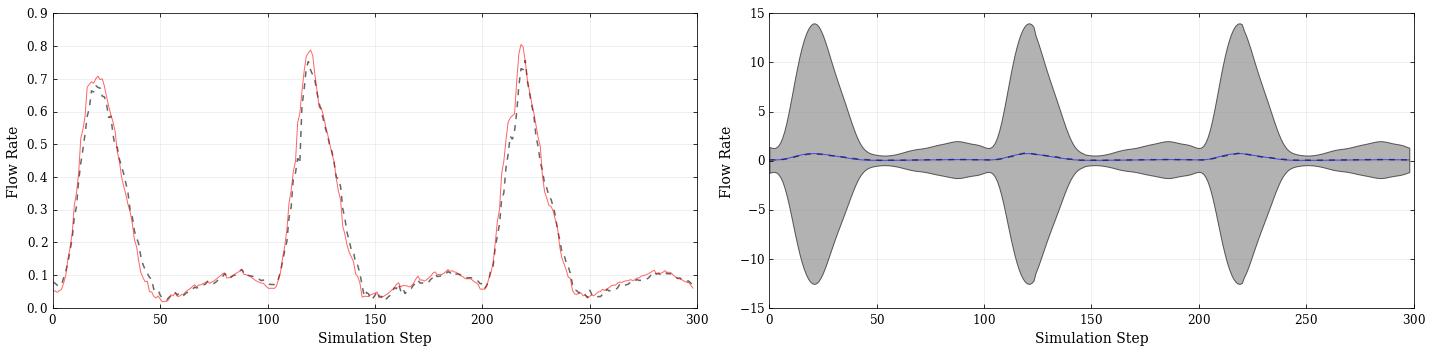

In [137]:
# PERFORM TESTING
# Compute a Polynomial Matrix at the Testing Locations
pTestMat = np.array(buildRegressionMatrix(pTestVals,maxPolyDegree).getMatrix())
# Compute the average reconstructed Qtys
olsQ = np.dot(pTestMat,olsCoeffs)
rvmQ = np.dot(pTestMat,rvmCoeffs)
# Compute the uncertainty region
olsAux = np.dot(np.dot(pTestMat,olsCoeffsCov),pTestMat.transpose())
rvmAux = np.dot(np.dot(pTestMat,rvmCoeffsCov),pTestMat.transpose())
shrink_idx = olsAux < 0
olsAux[shrink_idx] = 0.0
shrink_idx = rvmAux < 0.0
rvmAux[shrink_idx] = 0.0
olsSTDQ = olsNoise + np.sqrt(olsAux)
rvmSTDQ = rvmNoise + np.sqrt(rvmAux)

# Re-permute array in the correct temporal order
test  = computeInversePermutation(test_idx,qTestVals[:,0])
olsQ  = computeInversePermutation(test_idx,olsQ)
rvmQ  = computeInversePermutation(test_idx,rvmQ)
olsQ2 = computeInversePermutation(test_idx,np.diag(olsSTDQ))
rvmQ2 = computeInversePermutation(test_idx,np.diag(rvmSTDQ))

# Write Covariance in Matrix Form
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(test)),test,'k--',label='Exact',alpha=0.6,lw=1.5)
plt.plot(np.arange(len(olsQ)),olsQ,'r-',label='OLS',alpha=0.6,lw=1.0)
plt.fill_between(np.arange(len(olsQ)),olsQ+olsQ2, olsQ-olsQ2,facecolor='gray',interpolate=True,alpha=0.6)
plt.xlabel('Simulation Step',fontsize=14)
plt.ylabel('Flow Rate',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.subplot(1,2,2)
plt.plot(np.arange(len(test)),test,'k--',label='Exact',alpha=0.6,lw=1.5)
plt.plot(np.arange(len(rvmQ)),rvmQ,'b-',label='RVM',alpha=0.6,lw=1.0)
plt.fill_between(np.arange(len(rvmQ)),rvmQ+rvmQ2, rvmQ-rvmQ2,facecolor='gray',interpolate=True,alpha=0.6)
plt.xlabel('Simulation Step',fontsize=14)
plt.ylabel('Flow Rate',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()